<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Assignment2/Assignment2_Project2_develop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 7.6MB/s 
     |████████████████████████████████| 901kB 36.9MB/s 
     |████████████████████████████████| 3.3MB 55.1MB/s 


In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import requests
import re
import string
import math
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Load the data

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

# Experiment focus on hate, irony and offensive
# Both 3 tasks can be run on the same code by alternating the "task" parameter below
# Other tasks have not been tested and may occur errors
task='hate'
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt", allow_redirects=True)
open('test_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt", allow_redirects=True)
open('test_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_labels.txt", allow_redirects=True)
open('train_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_text.txt", allow_redirects=True)
open('train_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_labels.txt", allow_redirects=True)
open('val_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_text.txt", allow_redirects=True)
open('val_text.txt', 'wb').write(r.content)

file = open('test_labels.txt')
test_labels = file.readlines()
file.close
file = open('test_text.txt')
test_text = file.readlines()
file.close
file = open('train_labels.txt')
train_labels = file.readlines()
file.close
file = open('train_text.txt')
train_text = file.readlines()
file.close
file = open('val_labels.txt')
val_labels = file.readlines()
file.close
file = open('val_text.txt')
val_text = file.readlines()
file.close

print("Number of total data:        ", len(train_labels)+len(val_labels)+len(test_labels))
print("Number of train labels:      ", len(train_labels))
print("Number of train text:        ", len(train_text))
print("Number of validation labels: ", len(val_labels))
print("Number of validation text:   ", len(val_text))
print("Number of test labels:       ", len(test_labels))
print("Number of test text:         ", len(test_text))

Number of total data:         4601
Number of train labels:       2862
Number of train text:         2862
Number of validation labels:  955
Number of validation text:    955
Number of test labels:        784
Number of test text:          784


In [ ]:
# Create subset from the dataset for system development
#test_labels = val_labels[:]
#test_text = val_text[:]
#train_labels = train_labels[500:2500]
#train_text = train_text[500:2500]
#val_labels = val_labels[:100]
#val_text = val_text[:100]

In [ ]:
# Download label mapping
import csv
import urllib.request
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
class_labels = [row[1] for row in csvreader if len(row) > 1]
print('Labels:', class_labels)

Labels: ['non_irony', 'irony']


In [ ]:
df = pd.DataFrame(data={'label': train_labels + val_labels + test_labels, 'text': train_text + val_text + test_text})
df

,label,text
0,1\n,seeing ppl walking w/ crutches makes me really...
1,0\n,"look for the girl with the broken smile, ask h..."
2,1\n,Now I remember why I buy books online @user #s...
3,1\n,@user @user So is he banded from wearing the c...
4,1\n,Just found out there are Etch A Sketch apps. ...
...,...,...
4767,0\n,Abraham was actually from modern day Iraq (Ur ...
4768,1\n,@user which one is more disturbing dan? Tickli...
4769,0\n,@user @user haha that's cool! I had a feeling ...
4770,1\n,@user @user Let the Western bastards bank acco...


In [ ]:
df['length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
df

,label,text,length
0,1\n,seeing ppl walking w/ crutches makes me really...,17
1,0\n,"look for the girl with the broken smile, ask h...",25
2,1\n,Now I remember why I buy books online @user #s...,12
3,1\n,@user @user So is he banded from wearing the c...,15
4,1\n,Just found out there are Etch A Sketch apps. ...,14
...,...,...,...
4767,0\n,Abraham was actually from modern day Iraq (Ur ...,17
4768,1\n,@user which one is more disturbing dan? Tickli...,20
4769,0\n,@user @user haha that's cool! I had a feeling ...,30
4770,1\n,@user @user Let the Western bastards bank acco...,19


In [ ]:
np.mean(df['length'][:len(train_text)].tolist())

17.360587002096437

  label  counts
0   0\n    2415
1   1\n    2357


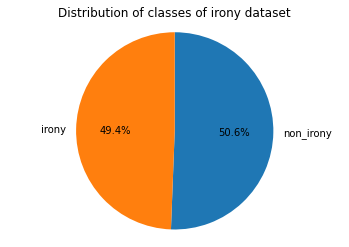

In [ ]:
# Show distribution of classes
df_class = df.groupby('label').size().reset_index(name='counts')
print(df_class)

labels = class_labels
sizes = df_class['counts'].tolist()
plt.title(f"Distribution of classes of {task} dataset")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

# Pre-processing

In [ ]:
# Cleaning the data
df['label'] = df['label'].apply(lambda x: re.sub('\n','', x))
df['text'] = df['text'].apply(lambda x: re.sub('\n','', x))
# Lowercase the words
df['cleaned'] = df['text'].apply(lambda x: x.lower())
# Remove digits and words containing digits
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
# Remove Punctuations
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Remove extra spaces
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
# Remove stop words
stop_words = set(nltk.corpus.stopwords.words("english"))
df['cleaned'] = df['cleaned'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

In [ ]:
%%time
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stop words removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

# Remove stop words again
df['lemmatized'] = df['lemmatized'].apply(lambda x: ' '.join([token for token in list(word_tokenize(x)) if not token in stop_words]))

df

CPU times: user 8min 29s, sys: 4.44 s, total: 8min 33s
Wall time: 8min 33s


# Experiment

In [ ]:
df['lemmatized'] = df['lemmatized'].astype(str)
train_text_list = df['lemmatized'][:len(train_text)].tolist()
val_text_list = df['lemmatized'][len(train_text):len(train_text) + len(val_text)].tolist()
test_text_list = df['lemmatized'][len(train_text) + len(val_text):].tolist()

df['label'] = df['label'].astype(int)
train_label_list = df['label'][:len(train_text)].tolist()
val_label_list = df['label'][len(train_text):len(train_text) + len(val_text)].tolist()
test_label_list = df['label'][len(train_text) + len(val_text):].tolist()

In [ ]:
%%time
# Creating feature vector
# Most frequently 3000 word is selected as the features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), max_features=3000)

# Only training set will be used to obtain features
train_set_vector = vectorizer.fit_transform(train_text_list)
val_set_vector = vectorizer.transform(val_text_list)
test_set_vector = vectorizer.transform(test_text_list)

train_set_label = [label for label in train_label_list]
val_set_label = [label for label in val_label_list]
test_set_label = [label for label in test_label_list]

CPU times: user 55.3 ms, sys: 2.02 ms, total: 57.4 ms
Wall time: 60.2 ms


In [ ]:
%%time
# Creating feature tensor
# Most frequently 3000 word is selected as the features
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
max_features = 3000
maxlen = 30
tokenizer = Tokenizer(num_words=3000)

# Only training set will be used to obtain features
tokenizer.fit_on_texts(train_text_list)

train_set_content = tokenizer.texts_to_sequences(train_text_list)
train_set_content = sequence.pad_sequences(train_set_content, maxlen=maxlen)
val_set_content = tokenizer.texts_to_sequences(val_text_list)
val_set_content = sequence.pad_sequences(val_set_content, maxlen=maxlen)
test_set_content = tokenizer.texts_to_sequences(test_text_list)
test_set_content = sequence.pad_sequences(test_set_content, maxlen=maxlen)

CPU times: user 131 ms, sys: 4.01 ms, total: 135 ms
Wall time: 152 ms


In [ ]:
import seaborn as sn
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

import keras
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional, TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier

# Conventional

In [ ]:
%%time
# Dummy (majority) is used as the classification model
Dummyclf = DummyClassifier(strategy='most_frequent')
# Train Dummy Classifier
Dummyclf = Dummyclf.fit(train_set_vector, train_set_label)

CPU times: user 1.13 ms, sys: 2 µs, total: 1.13 ms
Wall time: 1.29 ms


In [ ]:
%%time
# Predict using test dataset
predicted_label = Dummyclf.predict(test_set_vector)

CPU times: user 157 µs, sys: 0 ns, total: 157 µs
Wall time: 288 µs


Majority:
Accuracy Score: 0.4774869109947644
Macro F1 Score: 0.32317505315379164
Clasification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       499
           1       0.48      1.00      0.65       456

    accuracy                           0.48       955
   macro avg       0.24      0.50      0.32       955
weighted avg       0.23      0.48      0.31       955



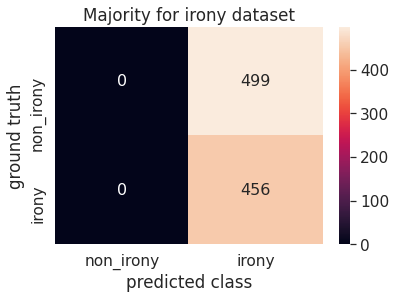

In [ ]:
print("Majority:")
#print('Best parameters: ', Dummyclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label, zero_division=0))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Majority for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Naive Bayes Classifier is used as the classification model
NBclf = MultinomialNB(alpha=1.0, fit_prior=True)
param_grid = {
    # 'fit_prior' : [True, False],
}
NBclf = GridSearchCV(estimator=NBclf, param_grid=param_grid, n_jobs=-1)
# Train Naive Bayes Classifier
NBclf = NBclf.fit(train_set_vector, train_set_label)

CPU times: user 95.6 ms, sys: 52 ms, total: 148 ms
Wall time: 1.03 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = NBclf.predict(test_set_vector)

CPU times: user 525 µs, sys: 995 µs, total: 1.52 ms
Wall time: 1.15 ms


Naive Bayes:
Best parameters:  {}
Accuracy Score: 0.5958115183246073
Macro F1 Score: 0.5957578867951012
Clasification report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.59       499
           1       0.57      0.64      0.60       456

    accuracy                           0.60       955
   macro avg       0.60      0.60      0.60       955
weighted avg       0.60      0.60      0.60       955



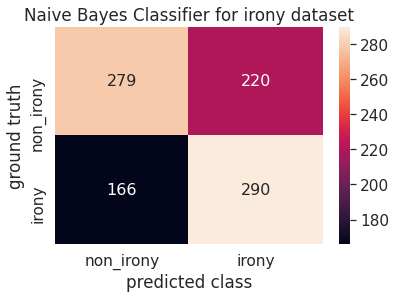

In [ ]:
print("Naive Bayes:")
print('Best parameters: ', NBclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Naive Bayes Classifier for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Decision Tree is used as the classification model
DTclf = DecisionTreeClassifier(criterion="entropy", min_samples_split=10)
param_grid = {
    # 'criterion' : ["entropy", "gini"],
    # 'max_depth' : np.arange(10, 21, 1),
    # 'min_samples_split' : np.arange(10, 21, 1),
}
DTclf = GridSearchCV(estimator=DTclf, param_grid=param_grid, n_jobs=-1)
# Train Decision Tree Classifier
DTclf = DTclf.fit(train_set_vector, train_set_label)

CPU times: user 407 ms, sys: 3.99 ms, total: 411 ms
Wall time: 1.47 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = DTclf.predict(test_set_vector)

CPU times: user 1.44 ms, sys: 0 ns, total: 1.44 ms
Wall time: 1.45 ms


Decision Tree:
Best parameters:  {}
Accuracy Score: 0.5780104712041885
Macro F1 Score: 0.5716912112481067
Clasification report:
               precision    recall  f1-score   support

           0       0.58      0.67      0.62       499
           1       0.57      0.48      0.52       456

    accuracy                           0.58       955
   macro avg       0.58      0.57      0.57       955
weighted avg       0.58      0.58      0.57       955



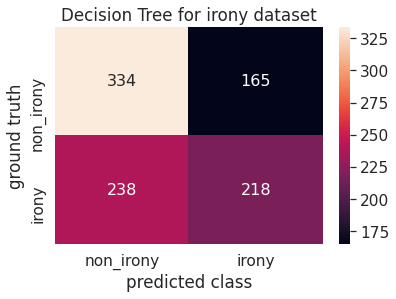

In [ ]:
print("Decision Tree:")
print('Best parameters: ', DTclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Decision Tree for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# K-Nearest Neighbors is used as the classification model
KNNclf = KNeighborsClassifier(weights="distance", p = 2, n_neighbors=5) #euclidean distance
param_grid = {
        #'n_neighbors': np.arange(1, 11, 1),
        #'weights': ["uniform", "distance"],
}
KNNclf = GridSearchCV(estimator=KNNclf, param_grid=param_grid, n_jobs=-1)
# Train K-Nearest Neighbors Classifier
KNNclf = KNNclf.fit(train_set_vector, train_set_label)

CPU times: user 71.9 ms, sys: 1 ms, total: 72.9 ms
Wall time: 193 ms


In [ ]:
%%time
# Predict using test dataset
predicted_label = KNNclf.predict(test_set_vector)

CPU times: user 63.3 ms, sys: 23 ms, total: 86.3 ms
Wall time: 91.1 ms


K-Nearest Neighbors:
Best parameters:  {}
Accuracy Score: 0.5790575916230366
Macro F1 Score: 0.5772177046349565
Clasification report:
               precision    recall  f1-score   support

           0       0.59      0.62      0.61       499
           1       0.56      0.54      0.55       456

    accuracy                           0.58       955
   macro avg       0.58      0.58      0.58       955
weighted avg       0.58      0.58      0.58       955



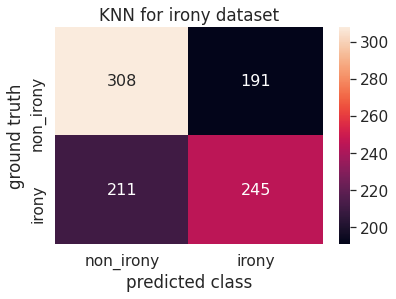

In [ ]:
print("K-Nearest Neighbors:")
print('Best parameters: ', KNNclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"KNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Support Vector Machine is used as the classification model
SVMclf = SVC(kernel='rbf', C=1, gamma=0.1)
param_grid = {
    #'kernel': ["linear", "poly", "rbf"],
    #'C' : np.logspace(-1, 3, 5),
    #'gamma' : np.logspace(-4, -0, 5),
}
SVMclf = GridSearchCV(estimator=SVMclf, param_grid=param_grid, n_jobs=-1)
# Train Support Vector Machine Classifier
SVMclf = SVMclf.fit(train_set_vector, train_set_label)

CPU times: user 745 ms, sys: 6.01 ms, total: 751 ms
Wall time: 2.77 s


In [ ]:
%%time
# Predict using test dataset
predicted_label = SVMclf.predict(test_set_vector)

CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 180 ms


Support Vector Machine:
Best parameters:  {}
Accuracy Score: 0.6094240837696335
Macro F1 Score: 0.6025047174074847
Clasification report:
               precision    recall  f1-score   support

           0       0.61      0.71      0.65       499
           1       0.61      0.50      0.55       456

    accuracy                           0.61       955
   macro avg       0.61      0.60      0.60       955
weighted avg       0.61      0.61      0.60       955



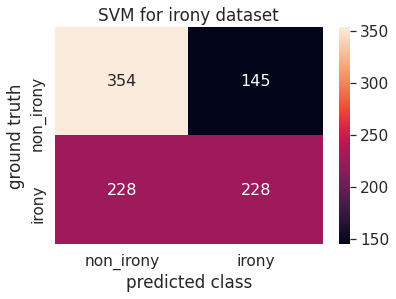

In [ ]:
print("Support Vector Machine:")
print('Best parameters: ', SVMclf.best_params_)
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SVM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

# Deep Learning

In [ ]:
%%time
# SimpleANN is used as the classification model
model = models.Sequential()
model.add(Dense(32, input_shape=(30,)))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleANN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,025
Trainable params: 1,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 1s 14ms/step - loss: 174.2621 - acc: 0.5060 - val_loss: 76.9375 - val_acc: 0.4775
Epoch 2/5
23/23 [==============================] - 0s 4ms/step - loss: 66.9587 - acc: 0.5035 - val_loss: 15.2418 - val_acc: 0.4848
Epoch 3/5
23/23 [==============================] - 0s 4ms/step - loss: 11.3060 - acc: 0.5167 - val_loss: 7.5036 - val_acc: 0.5037
Epoch 4/5
23/23 [==============================] - 0s 4ms/step - loss: 7.1422 - acc: 0.5103 - val_loss: 5.5556 - val_acc: 

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 113 ms, sys: 5.02 ms, total: 118 ms
Wall time: 115 ms


SimpleANN:
Accuracy Score: 0.4827225130890052
Macro F1 Score: 0.4081449848451394
Clasification report:
               precision    recall  f1-score   support

           0       0.52      0.12      0.20       499
           1       0.48      0.88      0.62       456

    accuracy                           0.48       955
   macro avg       0.50      0.50      0.41       955
weighted avg       0.50      0.48      0.40       955



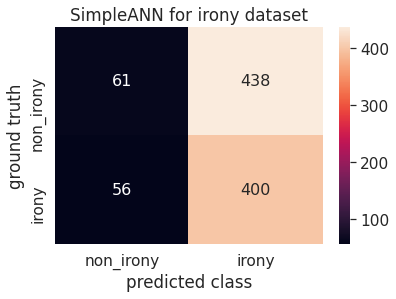

In [ ]:
print("SimpleANN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleANN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# SimpleRNN is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train SimpleRNN Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          96000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 98,113
Trainable params: 98,113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 2s 23ms/step - loss: 0.6916 - acc: 0.5273 - val_loss: 0.6911 - val_acc: 0.5141
Epoch 2/5
23/23 [==============================] - 0s 12ms/step - loss: 0.6440 - acc: 0.7159 - val_loss: 0.6771 - val_

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 211 ms, sys: 7.04 ms, total: 218 ms
Wall time: 200 ms


SimpleRNN:
Accuracy Score: 0.5685863874345549
Macro F1 Score: 0.562892159476706
Clasification report:
               precision    recall  f1-score   support

           0       0.63      0.43      0.51       499
           1       0.54      0.71      0.61       456

    accuracy                           0.57       955
   macro avg       0.58      0.57      0.56       955
weighted avg       0.58      0.57      0.56       955



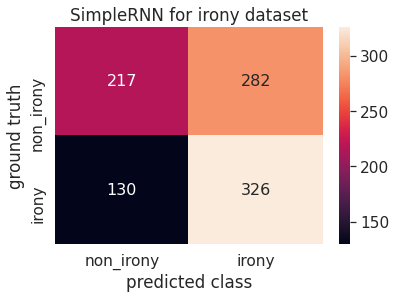

In [ ]:
print("SimpleRNN:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"SimpleRNN for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 3s 46ms/step - loss: 0.6930 - acc: 0.5128 - val_loss: 0.6896 - val_acc: 0.5445
Epoch 2/5
23/23 [==============================] - 1s 24ms/step - loss: 0.6805 - acc: 0.6297 - val_loss: 0.6792 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 497 ms, sys: 12.1 ms, total: 509 ms
Wall time: 447 ms


LSTM:
Accuracy Score: 0.6073298429319371
Macro F1 Score: 0.6056678129139457
Clasification report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63       499
           1       0.59      0.57      0.58       456

    accuracy                           0.61       955
   macro avg       0.61      0.61      0.61       955
weighted avg       0.61      0.61      0.61       955



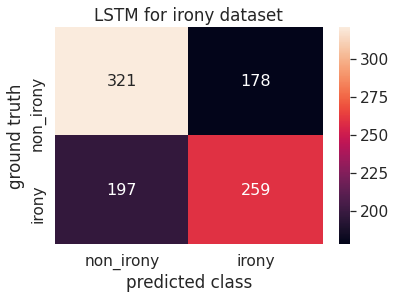

In [ ]:
print("LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 112,705
Trainable params: 112,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 5s 68ms/step - loss: 0.6925 - acc: 0.5173 - val_loss: 0.6925 - val_acc: 0.4942
Epoch 2/5
23/23 [==============================] - 1s 34ms/step - loss: 0.6790 - acc: 0.5893 - val_loss: 0.6766 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 1.16 s, sys: 31 ms, total: 1.19 s
Wall time: 1.07 s


BiLSTM:
Accuracy Score: 0.6157068062827226
Macro F1 Score: 0.6128525208742728
Clasification report:
               precision    recall  f1-score   support

           0       0.62      0.67      0.65       499
           1       0.61      0.55      0.58       456

    accuracy                           0.62       955
   macro avg       0.61      0.61      0.61       955
weighted avg       0.62      0.62      0.61       955



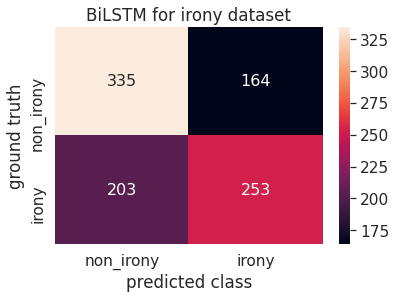

In [ ]:
print("BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical LSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical LSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 120,993
Trainable params: 120,993
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 1.67 s, sys: 32.3 ms, total: 1.7 s
Wall time: 1.53 s


Hierarchical LSTM:
Accuracy Score: 0.606282722513089
Macro F1 Score: 0.5827057882895446
Clasification report:
               precision    recall  f1-score   support

           0       0.59      0.81      0.68       499
           1       0.65      0.39      0.48       456

    accuracy                           0.61       955
   macro avg       0.62      0.60      0.58       955
weighted avg       0.62      0.61      0.59       955



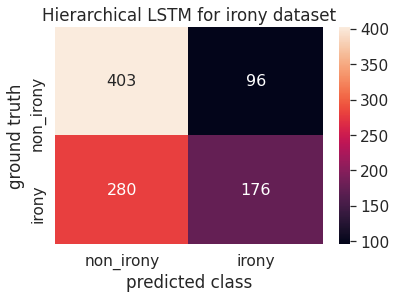

In [ ]:
print("Hierarchical LSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical LSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# Hierarchical BiLSTM is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train Hierarchical BiLSTM Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 162,369
Trainable params: 162,369
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 2.46 s, sys: 52.1 ms, total: 2.51 s
Wall time: 2.14 s


Hierarchical BiLSTM:
Accuracy Score: 0.5958115183246073
Macro F1 Score: 0.594044860669386
Clasification report:
               precision    recall  f1-score   support

           0       0.64      0.51      0.57       499
           1       0.56      0.69      0.62       456

    accuracy                           0.60       955
   macro avg       0.60      0.60      0.59       955
weighted avg       0.60      0.60      0.59       955



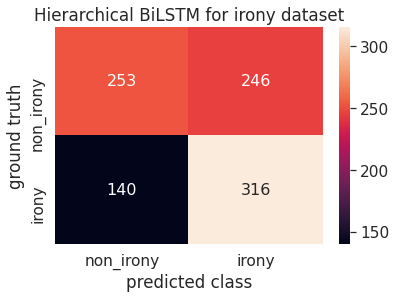

In [ ]:
print("Hierarchical BiLSTM:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"Hierarchical BiLSTM for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
%%time
# BiGRU is used as the classification model
model = models.Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(GRU(32)))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# Train BiGRU Classifier
history = model.fit(train_set_content, np.array(train_set_label), 
                    epochs=5,
                    batch_size=128,
                    #validation_split=0.2,
                    validation_data=(val_set_content, np.array(val_set_label)),
                    )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          96000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                12672     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 108,737
Trainable params: 108,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
23/23 [==============================] - 5s 67ms/step - loss: 0.6923 - acc: 0.5210 - val_loss: 0.6889 - val_acc: 0.5319
Epoch 2/5
23/23 [==============================] - 1s 34ms/step - loss: 0.6762 - acc: 0.6356 - val_loss: 0.6764 - va

In [ ]:
%%time
# Predict using test dataset
#model.evaluate(val_set_content, np.array(val_set_label))
predicted_label = model.predict(test_set_content)
predicted_label = np.around(predicted_label)

CPU times: user 800 ms, sys: 22 ms, total: 822 ms
Wall time: 717 ms


BiGRU:
Accuracy Score: 0.6083769633507854
Macro F1 Score: 0.5706761097007461
Clasification report:
               precision    recall  f1-score   support

           0       0.58      0.87      0.70       499
           1       0.69      0.33      0.44       456

    accuracy                           0.61       955
   macro avg       0.64      0.60      0.57       955
weighted avg       0.63      0.61      0.58       955



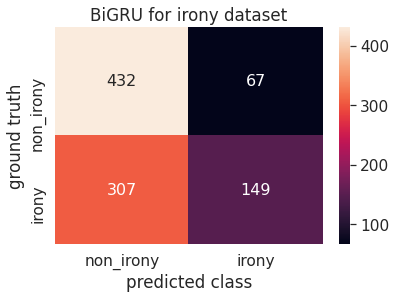

In [ ]:
print("BiGRU:")
accuracy = metrics.accuracy_score(test_set_label, predicted_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, predicted_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, predicted_label))

cm = confusion_matrix(test_set_label, predicted_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"BiGRU for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = [
    ]
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
%%time
# RoBERTa is used as the classification model
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

#golden_label = [i[1] for i in test_set]
tested_label = []
for i in range(len(test_text)):
  text = test_text[i]
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  tested_label.append(np.argmax(scores))


CPU times: user 2min 11s, sys: 2.8 s, total: 2min 13s
Wall time: 2min 21s


RoBERTa:
Accuracy Score: 0.7926701570680629
Macro F1 Score: 0.792077182920178
Clasification report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78       499
           1       0.73      0.89      0.80       456

    accuracy                           0.79       955
   macro avg       0.80      0.80      0.79       955
weighted avg       0.81      0.79      0.79       955



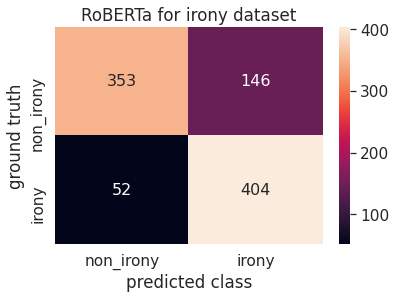

In [ ]:
print("RoBERTa:")
accuracy = metrics.accuracy_score(test_set_label, tested_label)
print('Accuracy Score:', accuracy)
f1= metrics.f1_score(test_set_label, tested_label, average='macro')
print('Macro F1 Score:', f1)
print('Clasification report:\n', metrics.classification_report(test_set_label, tested_label))

cm = confusion_matrix(test_set_label, tested_label)
df_cm = pd.DataFrame(cm, class_labels, class_labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.title(f"RoBERTa for {task} dataset")
plt.xlabel('predicted class')
plt.ylabel('ground truth')
plt.show()